### 1.Problem defintion

Fraud detection in mobile money transactions. Predicting whether the transaction if a fraud or not is a classification problem. In this case this is a binary classification.

### 2.Data

The dataset can be downloaded from: https://www.kaggle.com/ntnu-testimon/paysim1

This dataset contains mobile money transactions which were generated with PaySim simulator. The simulation was based on a sample of real transactions gathered by a company who is the provider of the mobile financial service which is currently runnig in more than 14 countries all around the world. The data is a set of one month financial logs from a mobile money service implemented in an African country. 


The data is gathered in one CSV file. One line sample row:
`1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0`
 
The dataset contains (following the example above):

* **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

* **amount** - amount of the transaction in local currency.

* **nameOrig** - customer who started the transaction

* **oldbalanceOrg** - initial balance before the transaction

* **newbalanceOrig** - new balance after the transaction

* **nameDest** - customer who is the recipient of the transaction

* **oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

* **newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

* **isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

* **isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluations
from sklearn.model_selection import train_test_split

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
df = pd.read_csv("../input/paysim1/PS_20174392719_1491204439457_log.csv")

In [3]:
# Let's see how the data looks like
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [4]:
# Some basic information about data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


We have object data types in here so we will have to turn them into numbers later on.

In [5]:
# Descriptive statistics
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
# Let's check if there are no missing values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
# We can check how many fraudile transactions there are in the dataset
(df["isFraud"] == 1).sum(), (df["isFraud"] == 0).sum(), (df["isFlaggedFraud"] == 1).sum()

(8213, 6354407, 16)

Only 16 from 8213 transactions were flagged as a fraud so that's not even a 1%. The reason is that only transactions with the amount of 200.000 are automatically flagged as a fraud (to be verified), there are no other limitations set. 

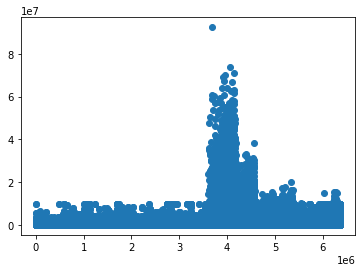

In [8]:
# Let's plot the transaction amounts
fig, ax = plt.subplots()
ax.scatter(df.index, df.amount);

In [9]:
# Let's turn non-numerical values into numbers
for label, content in df.items():
    if not pd.api.types.is_numeric_dtype(content):
        df[label] = pd.Categorical(content).codes+1

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,4,9839.64,757870,170136.0,160296.36,1662095,0.0,0.0,0,0
1,1,4,1864.28,2188999,21249.0,19384.72,1733925,0.0,0.0,0,0
2,1,5,181.00,1002157,181.0,0.00,439686,0.0,0.0,1,0
3,1,2,181.00,5828263,181.0,0.00,391697,21182.0,0.0,1,0
4,1,4,11668.14,3445982,41554.0,29885.86,828920,0.0,0.0,0,0


### 3.Modeling

In [10]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [11]:
np.random.seed(37)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Machine learning models:
1. Logistic Regression
2. K-Nearest Neighbours Classifier
3. Random Forest Classifier
4. SGD Classifier

In [12]:
model = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "SGD": SGDClassifier()}

def fit_and_evaluate(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates machine learning models.
    models: a dictionary with machine learning models to be used
    X_train: training data (no labels)
    X_test: testing data (no labels)
    y_train: training labels
    y_test: testing labels
    """
    # Create an empty dictionary for model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [13]:
model_scores = fit_and_evaluate(models = model,
                                X_train = X_train,
                                X_test = X_test,
                                y_train = y_train,
                                y_test = y_test)
model_scores

{'Logistic Regression': 0.9991489355014129,
 'KNN': 0.9993233919360264,
 'Random Forest': 0.9997060959164621,
 'SGD': 0.999129289506524}